In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.consignes{
  font-weight: bold;
  color: #3256a8;
  background-color: #edebdf
}
</style>
""")

# <div class=consignes>Deep Learning et traitement du signal TP 1 </div>
<div class=consignes> L'objectif de ce TP est de prendre en main les outils de modélisation et d'analyse du signal présentés dans le premier cours et d'introduire la problématique de <it>détection</it> dont on parlera dans le cours numéro 3 </div>
<div class=consignes>Deadline : 16 octobre 2024, 13h59, par mail à deepetsignal.mva@gmail.com <br> Effort estimé : 2 à 3 heures maximum</div>
<div class=consignes>Le rendu de ce TP n'est pas obligatoire. Il permet d'obtenir un bonus de 1 (minimum syndical) à 3 (votre notebook servira de correction l'an prochain) points sur la moyenne des TP </div>

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp1.ipynb </div>

<div class=consignes>Si vous installez des paquets supplémentaires, merci de les lister dans la cellule suivante avec la syntaxe
    
```
!pip install \< nom_du_paquet \>
```
    
</div>

In [3]:
import numpy as np
import matplotlib.pylab as plt
import scipy
import IPython.display as ipd

## <div class=consignes>Partie 1: Audio </div>

### <div class=consignes>Visualisation</div>

 <div class=consignes>Enregistrez un fichier wav de quelques secondes de votre voix.
  <br>
 Importez le avec scipy.io.wavfile.read et écoutez le dans le notebook avec IPython.display.Audio
</div>

In [4]:
import scipy.io.wavfile as wavfile

#Lire le fichier wav
sample_rate, data = wavfile.read('coloniedefourmies.wav')
#sample_rate, data = wavfile.read('test.wav')

#Écouter le fichier audio dans le notebook
ipd.Audio(data=data, rate=sample_rate)


<div class=consignes>Visualisez la forme d'onde temporelle de ce signal audio. <br>
Estimez et affichez sa Densité Spectrale de Puissance. <br>
Donnez une interprétation de ce que vous observez.
    </div>

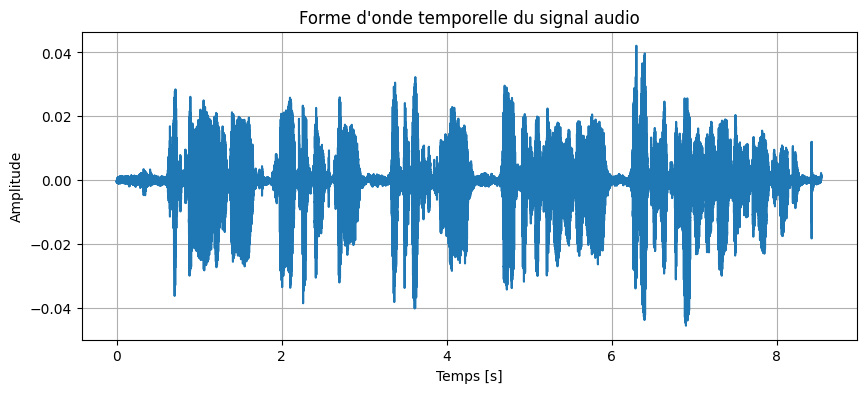

In [21]:
#Visualisation de la forme d'onde temporelle du signal audio
time = np.linspace(0, len(data) / sample_rate, num=len(data))
plt.figure(figsize=(10, 4))
plt.plot(time, data)
plt.title("Forme d'onde temporelle du signal audio")
plt.xlabel("Temps [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()
#data

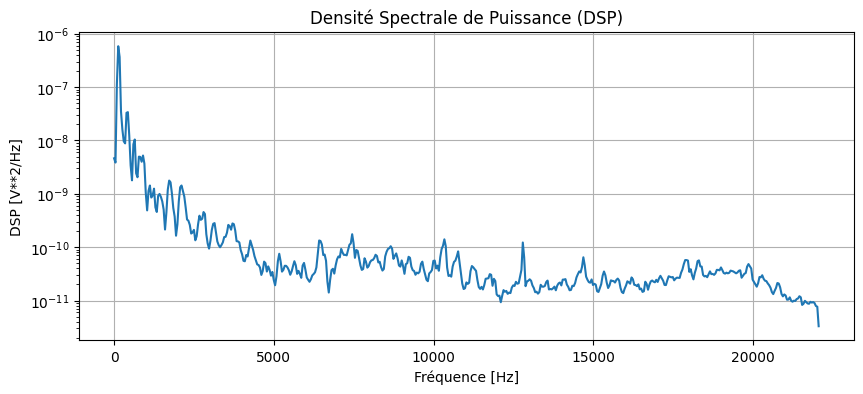

In [6]:
#Estimation et affichage de la densité spectrale de la puissance en utilisant la méthode de welch
from scipy.signal import welch
frequencies, DSP = welch(data, sample_rate, nperseg=1024)
plt.figure(figsize=(10, 4))
plt.semilogy(frequencies, DSP)
plt.title("Densité Spectrale de Puissance (DSP)")
plt.xlabel("Fréquence [Hz]")
plt.ylabel("DSP [V**2/Hz]")
plt.grid(True)
plt.show()


 
- On remarque la présence d'un pic dans les basses fréquences entre 0 et 500 Hz. Ce pic correspond probablement à la fréquence fondamentale. 
- Nous remarquons aussi la diminution progressive de la puissance à partir de 5kHz, ceci indique que la majorité de l'énergie du signal est concentré dans les basses fréquences.


<div class=consignes> Calculez et affichez le spectrogramme du signal. <br>
Justifiez du choix des réglages que vous avez faits. <br>
Sélectionnez une portion pertinente du spectrogramme pour estimer visuellement le pitch de votre voix.
    </div>

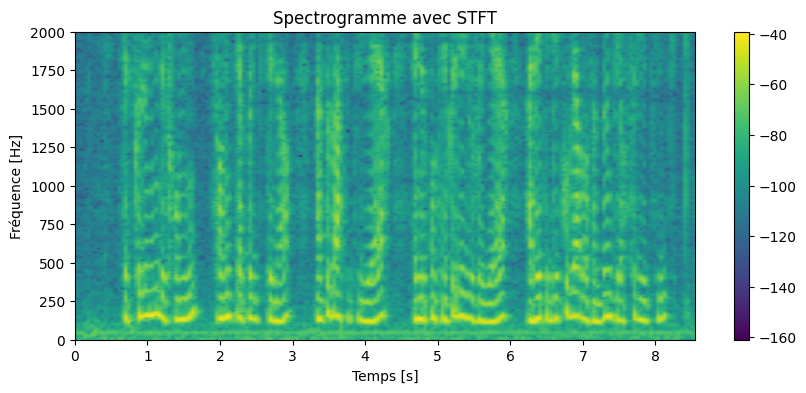

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft

# Calcul de la STFT
frequencies, times, Zxx = stft(data, fs=sample_rate, nperseg=2048*2, noverlap=2048)

# Amplitude du spectrogramme en décibels
amplitude_spectrogram_db = 20 * np.log10(np.abs(Zxx)) 

# Tracé du spectrogramme en décibels
plt.figure(figsize=(10, 4))

plt.pcolormesh(times, frequencies, amplitude_spectrogram_db, shading='gouraud', cmap='viridis')  
plt.title('Spectrogramme avec STFT')
plt.xlabel('Temps [s]')
plt.ylabel('Fréquence [Hz]')
plt.ylim(0, 2000) 

plt.colorbar()

plt.show()


- Le paramètre **nperseg** a été fixé à 4096, car cela représente un bon compromis pour un signal audio. Un nombre de fenêtres plus élevé améliore la résolution en fréquence. Avant de retenir cette valeur, nous avons testé des segments plus petits et constaté que les fréquences étaient alors moins discernables.
- noverlap = 2048, permet d'avoir un chevauchement à 50% 2048, ce qui permet de capturer les détails sans introduire trop de bruit.

Pour estimer le pitch de la voix, nous nous focalisons sur la fréquence fondamentale, généralement comprise entre 70 et 600 Hz pour la voix humaine. Dans notre cas, nous avons observé que la fréquence fondamentale se situe entre 70 et 250 Hz (la plage pour laquelle l'énergie est plus intense).

### <div class=consignes>Calcul du Pitch</div>

<div class=consignes>Proposez une méthode simple pour estimer automatiquement le Pitch de votre voix (cette méthode ne doit pas faire intervenir d'implémentations externes).

Utilisez cette méthode pour estimer les variations du Pitch le long du signal, estimez le pitch toutes les 20 ms et présentez vos résultats sous forme visuelle.

Ne pas utiliser de méthode "toute faite" que vous pourriez par exemple trouver dans la bibliothèque librosa.

Commentez vos résultats.
    </div>

Moyenne des pitchs: 105.54 Hz


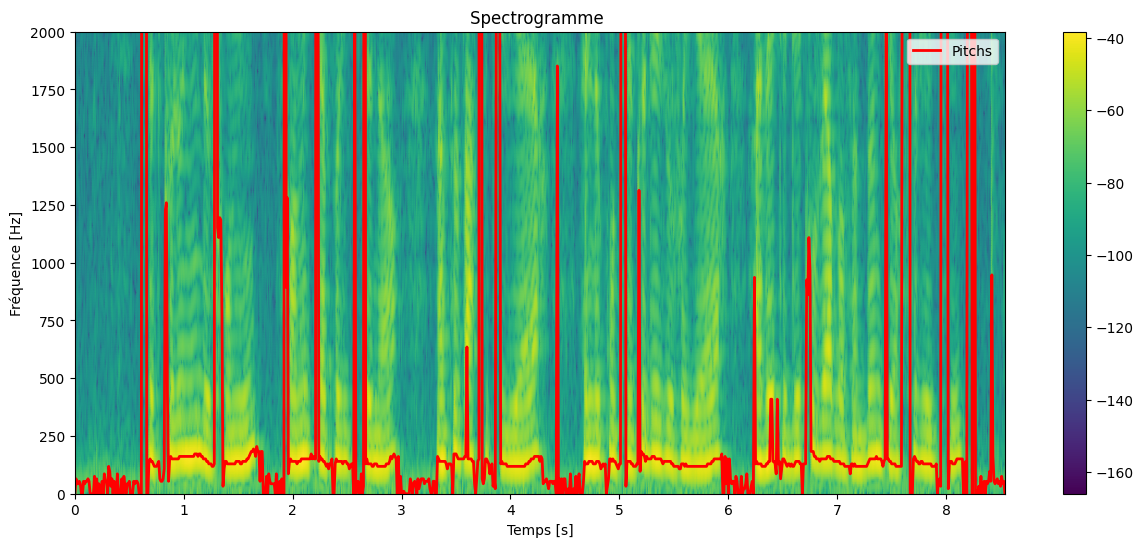

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft

frame_duration = 0.02  # 20 ms
window_size = int(sample_rate * frame_duration)  # nombre de points pour chaque fenêtre de 20 ms

# Calcul du STFT
frequencies, times, Zxx = stft(data, fs=sample_rate, nperseg=window_size, noverlap=window_size//2, nfft=2048*2)

# Magnitude du spectrogramme
Sxx = np.abs(Zxx)

# Initialiser une liste pour stocker les pitchs
pitches = []
filtered_pitches = []

# Parcourir chaque fenêtre temporelle pour récupérer les fréquences maximales
for i in range(Sxx.shape[1]):
    # Cherche la fréquence avec l'amplitude maximale pour cette fenêtre
    max_idx = np.argmax(Sxx[:, i])
    pitch = frequencies[max_idx]
    pitches.append(pitch)
    if pitch < 600:
        filtered_pitches.append(pitch)

# Calcul de la moyenne des pitchs
average_pitch = np.mean(filtered_pitches)

# Affichage du résultat
print(f'Moyenne des pitchs: {average_pitch:.2f} Hz')

#Affichage du spectrogramme avec les pitchs
plt.figure(figsize=(10, 4))

# Affichage du spectrogramme avec la palette vert/jaune
plt.pcolormesh(times, frequencies, 20 * np.log10(Sxx), shading='gouraud', cmap='viridis')  # 'summer' pour vert/jaune
plt.title('Spectrogramme ')
plt.xlabel('Temps [s]')
plt.ylabel('Fréquence [Hz]')
plt.ylim(0, 2000)

plt.colorbar()

# Affichage des pitchs sur le spectrogramme
plt.plot(times, pitches, color='r', label="Pitchs", linewidth=2)
plt.legend()

plt.show()


Cette méthode consiste à parcourir chaque fenêtre de 20 ms et à calculer le pitch pour chacune d'elles. Ensuite, le pitch final de la voix est déterminé comme étant la valeur moyenne de tous les pitchs trouvés.

Nous remarquons que les pitchs suivent majoritairement les fréquences basses (<250 Hz), bien que quelques pics d'harmoniques plus élevées apparaissent à certains moments. Il pourrait s'agir de périodes de silence ou de moments où un bruit important est présent.

## <div class=consignes>Partie 2: Détection d'impulsion </div>

<div class=consignes> Un signal de durée 1 seconde et échantillonné à 1000 Hz est composé d'un bruit blanc gaussien de puissance inconnue et éventuellement d'une impulsion à une fréquence f0 comprise entre 100 et 200 Hz.
<br><br>
Une série de 1000 signaux est enregistrée dans le fichier signaux_impulsions.npz.
Ouvez ce fichier avec numpy (cf code plus bas). Le fichier contient une tableau signaux 10000 x 1000 dont chaque ligne contient un signal de durée 1000. Le fichiez contient aussi un tableau labels de taille 10000 dont la ligne i est à TRUE si le signal i contient une impulsion et à 0 sinon.

</div>

In [10]:
donnees = np.load('signaux_impulsions.npz')
signaux = donnees['data']
labels = donnees['labels']


## <div class=consignes> Première méthode </div>

<div class=consignes> Proposez une méthode simple  pour décider si un signal contient une impulsion ou non à partir du calcul de l'énergie du signal. Cette méthode fera intervenir un seuil:
</div>

```python
def contient_impulsion_energie(signal: np.ndarray, seuil: float) -> bool:
```

Regardons la distribution des énergies pour les signaux avec impulsion et les signaux sans impulsion :

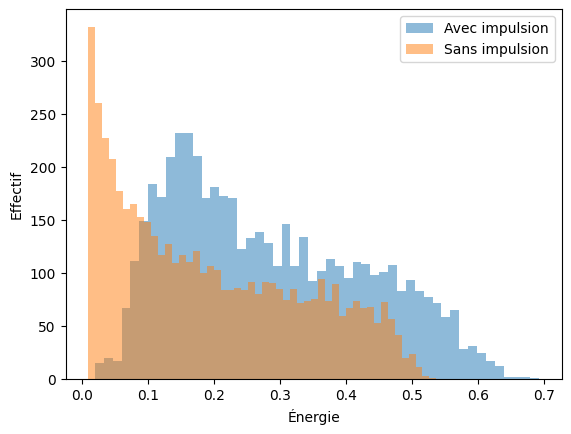

In [11]:
# Calcul de l'énergie de chaque signal
fe = 1000
energies = (1/fe)*np.sum(signaux**2, axis=1)

plt.hist(energies[labels == True], bins=50, alpha=0.5, label='Avec impulsion')
plt.hist(energies[labels == False], bins=50, alpha=0.5, label='Sans impulsion')
plt.xlabel('Énergie')
plt.ylabel('Effectif')
plt.legend()
plt.show()

In [12]:
def contient_impulsion_energie(signal, seuil):
    fe = 1000  # fréquence d'échantillonnage
    Te = 1 / fe  # période d'échantillonnage
    energie = Te * np.sum(signal**2)  # calcul de l'énergie
    return energie > seuil  # renvoie True si l'énergie dépasse le seuil, sinon False

<div class=consignes>
Utilisez votre méthode avec un seuil fixé sur tous les signaux pour prédire s'ils contiennent une impulsion ou non.
</div>

In [13]:
seuil = 0.1  # Exemple de seuil, à ajuster selon les données

# Prédictions pour tous les signaux
predictions = np.array([contient_impulsion_energie(signal, seuil) for signal in signaux])

# Précision de la méthode pour le seuil choisi.
accuracy = np.mean(predictions == labels)
print(f"Précision : {accuracy * 100:.2f}%")


Précision : 63.98%


<div class=consignes>
Calculez: <br>
- VP = le nombre de signaux que vous détectez comme contenant une impulsion qui contiennet effectivement une impulsion <br>
- FP = le nombre de signaux que vous détectez comme contenant une impulsion qui ne contiennet en fait PAS une impulsion <br>
- VN = le nombre de signaux que vous détectez comme ne contenant PAS une impulsion qui ne contiennet effectivement PAS une impulsion<br>
- FN = le nombre de signaux que vous détectez comme ne contenant PAS une impulsion mais qui  contiennet en fait une impulsion
</div>

In [14]:
VP = np.sum((predictions == True) & (labels == True))
VN = np.sum((predictions == False) & (labels == False))
FP = np.sum((predictions == True) & (labels == False))
FN = np.sum((predictions == False) & (labels == True))

print(f"VP = {VP}")
print(f"FP = {FP}")
print(f"VN = {VN}")
print(f"FN = {FN}")

VP = 4629
FP = 3227
VN = 1769
FN = 375


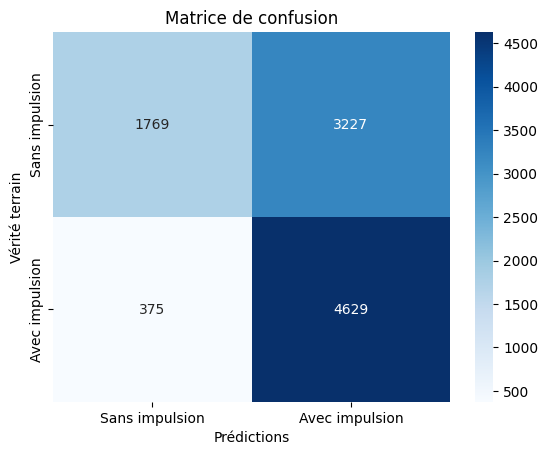

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcul de la matrice de confusion
cm = confusion_matrix(labels, predictions)

# Afficher la matrice de confusion
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sans impulsion', 'Avec impulsion'], yticklabels=['Sans impulsion', 'Avec impulsion'])
plt.xlabel('Prédictions')
plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion')
plt.show()

  Le modèle détecte correctement un grand nombre de signaux avec impulsion (4629), mais il a aussi un nombre assez élevé de faux positifs (3227), ce qui signifie qu'il a tendance à détecter des impulsions dans des signaux qui n'en ont pas.

  Il y a aussi un nombre significatif de faux négatifs (375), ce qui montre que certaines impulsions ne sont pas détectées par le modèle.

  Le nombre de vrais négatifs est relativement plus faible (1769), ce qui montre que le modèle pourrait être biaisé vers la détection d'impulsions, même dans des signaux qui n'en contiennent pas.

Cela suggère qu'il pourrait être utile d'ajuster le seuil d'énergie pour réduire les erreurs, en particulier les faux positifs.





## <div class=consignes>Deuxième méthode </div>

<div class=consignes>Proposez une deuxième méthode faisant par exemple intervenir le spectrogramme du signal. Cette méthode fera encore intervenir un seuil
</div>

```python
def contient_impulsion_spectrogramme(signal: np.ndarray, seuil: float) -> bool:
```


In [16]:
from scipy.signal import stft

def contient_impulsion_spectrogramme(signal, seuil, fe=1000):
    # Calculer la STFT
    f, t, Zxx = stft(signal, fs=fe, nperseg=256)

    # Filtrer les fréquences entre 100 Hz et 200 Hz
    idx_band = (f >= 100) & (f <= 200)

    df = f[1] - f[0]
    dt = t[1] - t[0]

    # Calculer l'énergie de la STFT du signal
    E_Zxx = np.sum(np.abs(Zxx[idx_band, :])**2) * df * dt  # on multiplie par df et dt

    return E_Zxx > seuil

<div class=consignes> Calculez pour cette nouvelle méthode, pour un certain seuil les valeurs de VP, FP, VN, FN </div>

Précision (STFT) : 74.48%
VP = 4878
FP = 2426
VN = 2570
FN = 126


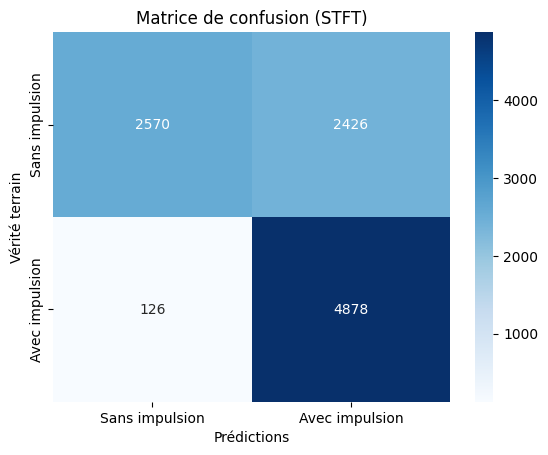

In [17]:
seuil_stft = 0.1

# Prédictions pour tous les signaux
predictions_stft = np.array([contient_impulsion_spectrogramme(signal, seuil_stft) for signal in signaux])

# Évaluer la précision de la méthode en comparant les prédictions aux labels réels
accuracy_stft = np.mean(predictions_stft == labels)
print(f"Précision (STFT) : {accuracy_stft * 100:.2f}%")

VP = np.sum((predictions_stft == True) & (labels == True))
VN = np.sum((predictions_stft == False) & (labels == False))
FP = np.sum((predictions_stft == True) & (labels == False))
FN = np.sum((predictions_stft == False) & (labels == True))

print(f"VP = {VP}")
print(f"FP = {FP}")
print(f"VN = {VN}")
print(f"FN = {FN}")

# Afficher la matrice de confusion
cm_stft = confusion_matrix(labels, predictions_stft)
sns.heatmap(cm_stft, annot=True, fmt='d', cmap='Blues', xticklabels=['Sans impulsion', 'Avec impulsion'], yticklabels=['Sans impulsion', 'Avec impulsion'])
plt.xlabel('Prédictions')
plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion (STFT)')
plt.show()

## <div class=consignes> Comparaison des méthodes </sdivs>

<div class=consignes>Pour une méthode de détection et un seuil donné, la précision est définie comme:
$$ \frac{\sharp\text{Signaux détectés comme contenant une impulsion qui en contiennent effectivement une}}{\sharp\text{Signaux détectés comme positifs }}$$
et le rappel comme:
$$ \frac{\sharp\text{Signaux détectés comme contenant une impulsion qui en contiennent effectivement une}}{\sharp \text{Signaux contenant une impulsions}} $$
    
</div>

<div class=consignes> Donnez une interprétation de ces deux métriques </div>

**La précision** est une mesure qui évalue la proportion des prédictions positives correctes parmi toutes les prédictions positives effectuées par le modèle. En d'autres termes, elle indique à quel point le modèle est efficace pour éviter les faux positifs. Une précision élevée signifie que lorsque le modèle prédit qu'un signal contient une impulsion, il est généralement correct dans cette affirmation.

En revanche, **le rappel** mesure la capacité du modèle à identifier toutes les instances réellement positives. Un rappel élevé indique que le modèle a réussi à capturer une grande partie des véritables instances positives présentes dans les données

<div class=consignes>
    Pour chacune des deux méthodes proposées, faites varier le seuil sur une dizaine de valeurs et calculez la précision et le rappel pour chacun de ces seuils.

Affichez dans le plan (précision , rappel) les points de fonctionnement des deux méthodes pour différents seuils. <br>Commentez le résultat.
    </div>

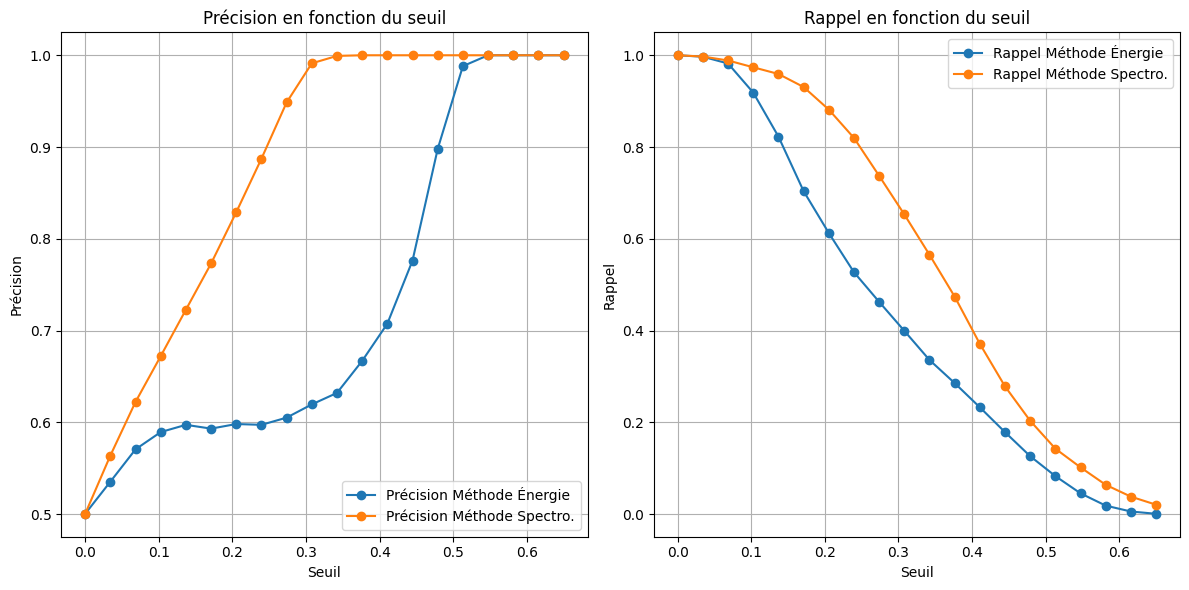

In [18]:
seuils = np.linspace(0, 0.65, 20)
precision_energie = []
rappel_energie = []
precision_stft = []
rappel_stft = []

# Évaluation pour la méthode basée sur l'énergie
for seuil in seuils:
    predictions = np.array([contient_impulsion_energie(signal, seuil) for signal in signaux])
    TP = np.sum((predictions == True) & (labels == True))
    FP = np.sum((predictions == True) & (labels == False))
    FN = np.sum((predictions == False) & (labels == True))

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    rappel = TP / (TP + FN) if (TP + FN) > 0 else 0

    precision_energie.append(precision)
    rappel_energie.append(rappel)

# Évaluation pour la méthode basée sur le spectrogramme
for seuil in seuils:
    predictions = np.array([contient_impulsion_spectrogramme(signal, seuil) for signal in signaux])
    TP = np.sum((predictions == True) & (labels == True))
    FP = np.sum((predictions == True) & (labels == False))
    FN = np.sum((predictions == False) & (labels == True))

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    rappel = TP / (TP + FN) if (TP + FN) > 0 else 0

    precision_stft.append(precision)
    rappel_stft.append(rappel)

# Visualisation des résultats
plt.figure(figsize=(12, 6))

# Précision
plt.subplot(1, 2, 1)
plt.plot(seuils, precision_energie, label='Précision Méthode Énergie', marker='o')
plt.plot(seuils, precision_stft, label='Précision Méthode Spectro.', marker='o')
plt.xlabel('Seuil')
plt.ylabel('Précision')
plt.title('Précision en fonction du seuil')
plt.legend()
plt.grid()

# Rappel
plt.subplot(1, 2, 2)
plt.plot(seuils, rappel_energie, label='Rappel Méthode Énergie', marker='o')
plt.plot(seuils, rappel_stft, label='Rappel Méthode Spectro.', marker='o')
plt.xlabel('Seuil')
plt.ylabel('Rappel')
plt.title('Rappel en fonction du seuil')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


Le compromis entre précision et rappel est un concept important dans les tâches de classification, où augmenter un indicateur entraîne souvent une diminution de l'autre. Ce compromis se produit parce qu'optimiser la précision nécessite généralement un seuil plus strict, ce qui peut diminuer le rappel, tandis qu'optimiser le rappel conduit souvent à un plus grand nombre de faux positifs, réduisant ainsi la précision.

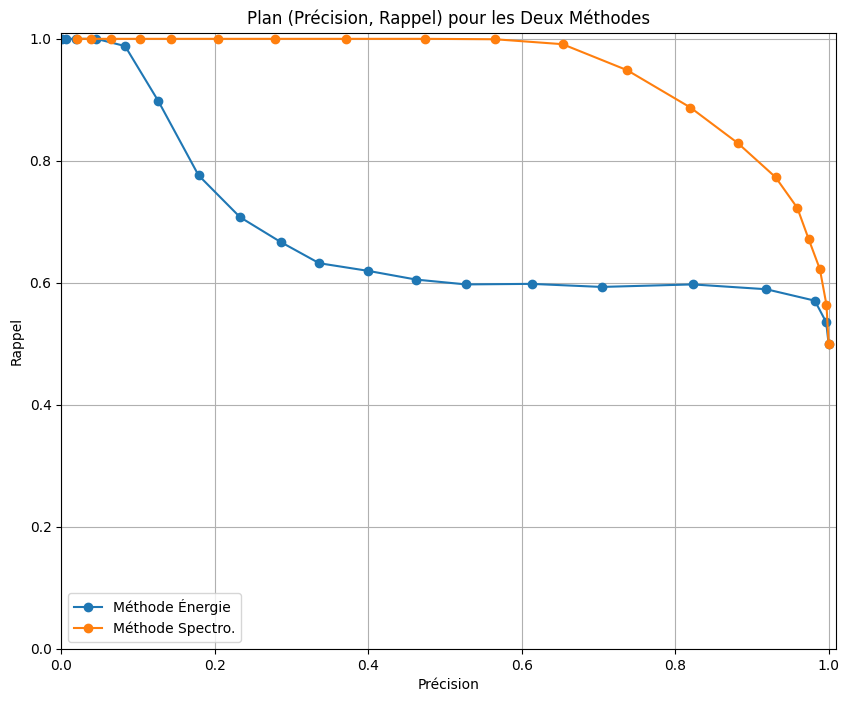

In [19]:
plt.figure(figsize=(10, 8))

# Points de fonctionnement pour la méthode basée sur l'énergie
plt.plot(rappel_energie, precision_energie, label='Méthode Énergie', marker='o')

# Points de fonctionnement pour la méthode basée sur la STFT
plt.plot(rappel_stft, precision_stft, label='Méthode Spectro.', marker='o')

plt.xlabel('Précision')
plt.ylabel('Rappel')
plt.title('Plan (Précision, Rappel) pour les Deux Méthodes')
plt.xlim(0, 1.01)
plt.ylim(0, 1.01)
plt.axhline(0, color='grey', lw=0.5, ls='--')
plt.axvline(0, color='grey', lw=0.5, ls='--')
plt.grid()
plt.legend()
plt.show()

 La courbe de précision-rappel est un outil efficace pour visualiser ce tradeoff entre la précision et le rappel, illustrant la relation entre précision et rappel à différents niveaux de seuil. Dans un scénario idéal, la courbe de précision-rappel d'un classificateur parfait toucherait le coin supérieur droit du graphique, indiquant à la fois une précision et un rappel élevés. De plus, on peut définir l'aire sous la courbe de précision-rappel, appelée PR-AUC, qui fournit une évaluation unique de notre modèle, indépendamment du seuil choisi. Plus cette aire est grande, meilleur est notre modèle.

In [20]:
from sklearn.metrics import auc

# Calculer l'aire sous la courbe de précision-rappel (PR-AUC)
pr_auc_energie = auc(rappel_energie, precision_energie)
pr_auc_stft = auc(rappel_stft, precision_stft)

# Affichage des résultats
print(f"Aire sous la courbe de précision-rappel (PR-AUC) pour la méthode basée sur l'énergie : {pr_auc_energie:.4f}")
print(f"Aire sous la courbe de précision-rappel (PR-AUC) pour la méthode basée sur le spectrogramme : {pr_auc_stft:.4f}")

Aire sous la courbe de précision-rappel (PR-AUC) pour la méthode basée sur l'énergie : 0.6726
Aire sous la courbe de précision-rappel (PR-AUC) pour la méthode basée sur le spectrogramme : 0.9293


Ces résultats (PR-AUC méthode énergie = 0.6726 < PR-AUC méthode spectrogramme = 0.9293) suggèrent qu'il serait plus judicieux d'utiliser la méthode basée sur le spectrogramme pour des tâches de détection d'impulsions dans des signaux bruités, surtout si la précision des prédictions est cruciale.

En résumé, la méthode STFT se révèle plus performante car elle cible précisément les fréquences pertinentes pour la détection des impulsions et fournit une analyse détaillée des variations temporelles et fréquentielles du signal. En se concentrant sur la plage de fréquences où les impulsions sont attendues, la STFT maximise la capacité de détection, contrairement à la méthode basée sur l'énergie, qui pourrait négliger des informations critiques en se basant sur une mesure globale de l'énergie.